In [136]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import pandas as pd
import seaborn as sb
import numpy as np
import os
import matplotlib.pyplot as plt
import math

import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
import random
import math
# from operator import itemgetter 
from sklearn import metrics
from sklearn.metrics import roc_auc_score, make_scorer, log_loss
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.utils import compute_class_weight
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier as RFClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from functools import partial
import warnings
warnings.filterwarnings('ignore')

In [137]:
from sklearn.metrics import (
    roc_auc_score, 
    f1_score, 
    precision_score, 
    recall_score, 
    accuracy_score, 
    matthews_corrcoef, 
    log_loss
)

In [138]:
# Load the dataset
os.chdir("D:/__PROJECTS/Cemo_VUS/2nd_paper/data2_vuscharac")
# data = pd.read_csv("clinvar_63genes_featues_polyphen.csv",sep=";") 
data = pd.read_csv("clinvar_63genes_featues_annovar_v3.csv",sep=";") 
data = data.loc[data["two_states"] !=2]
data = data.loc[data["hold_out"] !=1]
data["two_states"] = data["two_states"].astype(int)
df = data.reset_index()
print(len(data))

features = [
    # 'length', 'GO_number', 'Int_number', 
            'Occurrence_in_proteins{%)_n', 'Volume_(A3)_n', 'kdHydrophobicity_n', 'Propensity_alpha_n', 
            'Occurrence_in_proteins{%)_m', 'Volume_(A3)_m', 'kdHydrophobicity_m', 'Propensity_alpha_m', 
            'Occurrence_in_proteins{%)_DELTAmn', 'Volume_(A3)_DELTAmn', 'kdHydrophobicity_DELTAmn', 'Propensity_alpha_DELTAmn', 
            # 'plddt_mean', 'plddt_median', 'plddt', 
    'ASA', 'SS_cat', 'b62', 'WT_PSIC', 'MUT_PSIC', 'DELTA_PSIC']

target = 'two_states'

X = df[features]
y = df[target]

X = X.to_numpy()
y= y.to_numpy()

2473


In [139]:
evals = 250
inner_f = 3
outer_f = 5
RND = 42

### XGBoost model

In [140]:
# Define hyperparameter search space for XGB
space = {
    'n_estimators': hp.choice('n_estimators', range(500, 2000)),
    'learning_rate': hp.loguniform('learning_rate', -10, 0),
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'min_child_weight': hp.loguniform('min_child_weight', -5, 5),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1),
    'gamma': hp.uniform('gamma', 0.05, 1),
    'alpha': hp.uniform('alpha', 0, 1),
    'lambda': hp.uniform('lambda', 0.01,1),
    'tree_method':'hist'
}

In [141]:
# Define objective function for XGB hyperopt optimization
def objective(params, X, y, cv):
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric= 'auc')
    score = np.average(cross_val_score(model, X, y, cv=cv, scoring='roc_auc'))
    return {'loss': -score, 'status': STATUS_OK}

def nested_cv(X, y, cv_outer, cv_inner, space):
    outer_scores = []
    logloss_scores = []
    best_score = None
    
    # Metric tracking
    auc_list, f1_list, precision_list, recall_list, accuracy_list, mcc_list = [], [], [], [], [], []
    best_test_set = None  # To store the test set
    
    for i, (train_idx, val_idx) in enumerate(cv_outer.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]     

        inner_scores = []
        logloss = []

        for j, (train_idx_inner, val_idx_inner) in enumerate(cv_inner.split(X_train, y_train)):
            X_train_inner, y_train_inner = X_train[train_idx_inner], y_train[train_idx_inner]
            X_val_inner, y_val_inner = X_train[val_idx_inner], y_train[val_idx_inner]
    
            # Hyperparameter tuning with inner cross-validation
            obj_func = partial(objective, X=X_train_inner, y=y_train_inner, cv=cv_inner)
            result = fmin(fn=obj_func, space=space, algo=tpe.suggest, max_evals=evals, 
                          rstate=np.random.default_rng(RND))

            # Fit model with best hyperparameters on entire training set
            params = {**space, **result}
            model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='auc')
            model.fit(X_train_inner, y_train_inner)
                        
            # Evaluate model on outer validation set
            y_val_pred_proba = model.predict_proba(X_val)[:, 1]
            y_val_pred = model.predict(X_val)
            
            # Metrics calculation
            auc = roc_auc_score(y_val, y_val_pred_proba)
            f1 = f1_score(y_val, y_val_pred)
            precision = precision_score(y_val, y_val_pred)
            recall = recall_score(y_val, y_val_pred)
            accuracy = accuracy_score(y_val, y_val_pred)
            mcc = matthews_corrcoef(y_val, y_val_pred)
            
            # Append metrics
            auc_list.append(auc)
            f1_list.append(f1)
            precision_list.append(precision)
            recall_list.append(recall)
            accuracy_list.append(accuracy)
            mcc_list.append(mcc)
            
            # Log loss calculation
            train_loss = log_loss(y_train, model.predict_proba(X_train))
            val_loss = log_loss(y_val, y_val_pred_proba)
            logloss.append((train_loss, val_loss))
            
            inner_scores.append(auc)
            
            # Update best model details
            if best_score is None or auc > best_score:
                best_score = auc
                best_train_indices = train_idx
                best_test_indices = val_idx
                best_model = str(i) + "_" + str(j)
                best_test_set = (X_val, y_val)  # Save test set of the best model
                            
        logloss_scores.append(logloss)
        outer_scores.append(inner_scores)
    
    # Metric summaries
    metrics_summary = {
        'AUC': (np.mean(auc_list), np.std(auc_list)),
        'F1': (np.mean(f1_list), np.std(f1_list)),
        'Precision': (np.mean(precision_list), np.std(precision_list)),
        'Recall': (np.mean(recall_list), np.std(recall_list)),
        'Accuracy': (np.mean(accuracy_list), np.std(accuracy_list)),
        'MCC': (np.mean(mcc_list), np.std(mcc_list))
    }
    
    return params, outer_scores, logloss_scores, best_train_indices, best_test_indices, best_score, best_model, best_test_set, metrics_summary


In [142]:
from sklearn.model_selection import StratifiedKFold

cv_outer = StratifiedKFold(n_splits=outer_f, shuffle=True, random_state=RND)
cv_inner = StratifiedKFold(n_splits=inner_f, shuffle=True, random_state=RND)

try:
    results = nested_cv(X, y, cv_outer, cv_inner, space)
    (best_params, scores, logloss, train_index_list, test_index_list, 
     best_score, best_model, best_test_set, metrics_summary) = results
    
    print("Best hyperparameters:", best_params)
    print("Best model:", best_model)
    print("Metrics Summary:")
    for metric, (mean, std) in metrics_summary.items():
        print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")
    
    # Save the test set
    X_test, y_test = best_test_set
    print("Best test set shapes:", X_test.shape, y_test.shape)
    np.save("X_test_best.npy", X_test)
    np.save("y_test_best.npy", y_test)
    
except Exception as e:
    print("Error:", e)


100%|█████████████████████████████████████████████| 250/250 [08:58<00:00,  2.16s/trial, best loss: -0.9520033713671543]
Best hyperparameters: {'n_estimators': np.int64(128), 'learning_rate': np.float64(0.2059948788182461), 'max_depth': np.int64(1), 'min_child_weight': np.float64(0.016719590585890936), 'subsample': np.float64(0.9528034068542816), 'colsample_bytree': np.float64(0.6935419234128507), 'gamma': np.float64(0.9449400849331138), 'alpha': np.float64(0.26406507559184295), 'lambda': np.float64(0.023557116084059915), 'tree_method': 'hist'}
Best model: 4_0
Metrics Summary:
AUC: Mean = 0.9423, Std = 0.0220
F1: Mean = 0.8766, Std = 0.0293
Precision: Mean = 0.8732, Std = 0.0368
Recall: Mean = 0.8804, Std = 0.0266
Accuracy: Mean = 0.8755, Std = 0.0304
MCC: Mean = 0.7513, Std = 0.0607
Best test set shapes: (494, 24) (494,)


In [143]:
### #Evaluate models
from sklearn import metrics
def evaluation_analysis(true_label,predicted,predictor):
    eval_results = dict({
                         "predictor" : predictor,
                         "size" : len(true_label),
                         "f1" : metrics.f1_score(true_label, predicted, average='binary'),
                         "precision": metrics.precision_score(true_label, predicted),
                         "recall": metrics.recall_score(true_label, predicted),
                         "accuracy": metrics.accuracy_score(true_label, predicted),
                         "matthews_corr": metrics.matthews_corrcoef(true_label, predicted),
                         "confusion_matrix": metrics.confusion_matrix(true_label, predicted)
                        })
    return(eval_results)

def evaluation_analysis2(true_label,predicted_score,predictor):
    eval_results = dict({
                         "predictor" : predictor,
                         "size" : len(true_label),
                         "auc": metrics.roc_auc_score(true_label, predicted_score),
                         "log_loss": metrics.log_loss(true_label, predicted_score),
                        })
    return(eval_results)

In [144]:
import pandas as pd
import numpy as np

os.chdir("D:/__PROJECTS/Cemo_VUS/2nd_paper/data2_vuscharac")
df = pd.read_csv("clinvar_63genes_featues_annovar_v3.csv",sep=";") 
df = df.loc[df["two_states"] !=2]
# Select the training and test sets that performed best
best_train = df.loc[df["hold_out"] !=1]
best_test = df.loc[df["hold_out"] !=0]

X_train = best_train[features]
y_train = best_train[target]
X_tst = best_test[features]
y_tst = best_test[target]

xgbs = xgb.XGBClassifier(**best_params, use_label_encoder=False,eval_metric='auc')
xgbs.fit(X_train, y_train)

import pickle
with open("HerCan_xgb.pkl", "wb") as file:
    pickle.dump(xgbs, file) 
    
y_pred = xgbs.predict(X_tst)
y_prob = xgbs.predict_proba(X_tst)[:,1]

best_test["HCPxgb_prob"] = y_prob
best_test["HCPxgb"] = y_pred
# print(y_pred,y_prob)

In [145]:
preds = ["HCPxgb",                     
'SIFT_pred', 
'Polyphen2_HDIV_pred',  
'Polyphen2_HVAR_pred',
'LRT_pred',  
'MutationTaster_pred', 
'MutationAssessor_pred', 
'FATHMM_pred', 
'PROVEAN_pred', 
'MetaSVM_pred', 
'MetaLR_pred', 
'M-CAP_pred', 
'fathmm-MKL_coding_pred']
# Evaluate other tools on outer validation set that performed best
#######################################
df = best_test
print(len(df))

d1=list()
for p in preds:
    dx = df.loc[~df[p].isna()]
    # print(len(dx))
    # print(p)
    dx[p] = dx[p].astype(int)
    # print(dx)
    d = pd.DataFrame([evaluation_analysis(dx["two_states"],dx[p],p)])
    d1.append(d) 
dx = pd.concat(d1)
display(dx)
dx.to_csv("xgb_evals1.csv",sep=";")


pred_probs = ["HCPxgb_prob",
              'SIFT_converted_rankscore', 
              'Polyphen2_HDIV_rankscore',
              'Polyphen2_HVAR_rankscore',
              'LRT_converted_rankscore',
              'MutationTaster_converted_rankscore',
              'MutationAssessor_score_rankscore',
              'FATHMM_converted_rankscore',
              'PROVEAN_converted_rankscore', 
              'VEST3_rankscore',
              'MetaSVM_rankscore', 
              'MetaLR_rankscore',
              'M-CAP_rankscore', 
              'CADD_raw_rankscore',
              'DANN_rankscore',
              'fathmm-MKL_coding_rankscore', 
              'GenoCanyon_score_rankscore',
              'integrated_fitCons_score_rankscore',
              'GERP++_RS_rankscore',
              'phyloP100way_vertebrate_rankscore',
              'phyloP20way_mammalian_rankscore', 
              'phastCons100way_vertebrate_rankscore',
              'phastCons20way_mammalian_rankscore',
              'SiPhy_29way_logOdds_rankscore']
d1=list()
for p in pred_probs:
    dx = df.loc[~df[p].isna()]
    dx[p] =pd.to_numeric(dx[p],downcast="integer")
    d = pd.DataFrame([evaluation_analysis2(dx["two_states"],dx[p],p)])
    d1.append(d) 
dx = pd.concat(d1)
display(dx)
dx.to_csv("xgb_evals2.csv",sep=";")

618


,predictor,size,f1,precision,recall,accuracy,matthews_corr,confusion_matrix
0,HCPxgb,618,0.895765,0.901639,0.889968,0.896440,0.792947,"[[279, 30], [34, 275]]"
0,SIFT_pred,612,0.813370,0.710462,0.951140,0.781046,0.597234,"[[186, 119], [15, 292]]"
0,Polyphen2_HDIV_pred,617,0.814404,0.711864,0.951456,0.782820,0.600598,"[[189, 119], [15, 294]]"
0,Polyphen2_HVAR_pred,617,0.822653,0.762431,0.893204,0.807131,0.623428,"[[222, 86], [33, 276]]"
0,LRT_pred,601,0.822485,0.745308,0.917492,0.800333,0.616903,"[[203, 95], [25, 278]]"
0,MutationTaster_pred,617,0.791005,0.668904,0.967638,0.743922,0.545143,"[[160, 148], [10, 299]]"
0,MutationAssessor_pred,596,0.801205,0.716981,0.907850,0.778523,0.578874,"[[198, 105], [27, 266]]"
0,FATHMM_pred,615,0.688478,0.614213,0.783172,0.643902,0.298489,"[[154, 152], [67, 242]]"
0,PROVEAN_pred,614,0.794212,0.789137,0.799353,0.791531,0.583058,"[[239, 66], [62, 247]]"
0,MetaSVM_pred,617,0.794349,0.771341,0.818770,0.787682,0.576416,"[[233, 75], [56, 253]]"


,predictor,size,auc,log_loss
0,HCPxgb_prob,618,0.950796,0.293336
0,SIFT_converted_rankscore,612,0.881353,0.447376
0,Polyphen2_HDIV_rankscore,617,0.861861,0.469882
0,Polyphen2_HVAR_rankscore,617,0.874884,0.467358
0,LRT_converted_rankscore,603,0.850891,0.467731
0,MutationTaster_converted_rankscore,617,0.817530,0.490720
0,MutationAssessor_score_rankscore,596,0.872481,0.476587
0,FATHMM_converted_rankscore,615,0.738271,0.972391
0,PROVEAN_converted_rankscore,614,0.887087,0.441746
0,VEST3_rankscore,615,0.932294,0.493145


HCPxgb 0.951


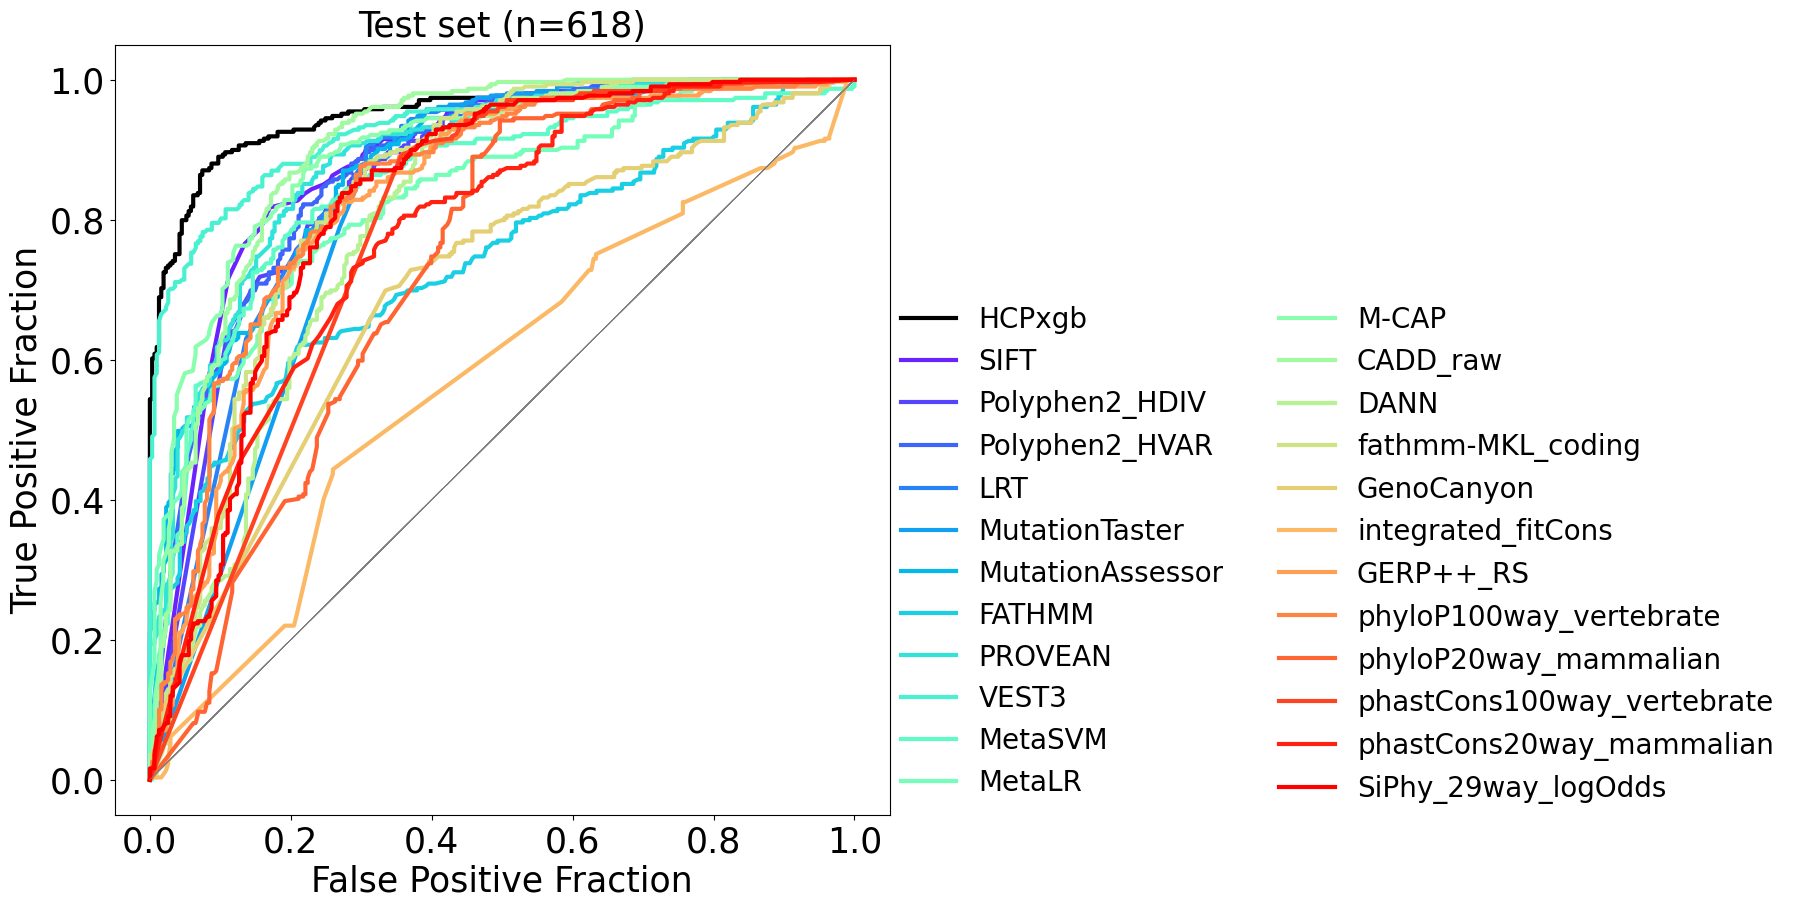

In [146]:
pred_probs = ["HCPxgb_prob",
              'SIFT_converted_rankscore', 
              'Polyphen2_HDIV_rankscore',
              'Polyphen2_HVAR_rankscore',
              'LRT_converted_rankscore',
              'MutationTaster_converted_rankscore',
              'MutationAssessor_score_rankscore',
              'FATHMM_converted_rankscore',
              'PROVEAN_converted_rankscore', 
              'VEST3_rankscore',
              'MetaSVM_rankscore', 
              'MetaLR_rankscore',
              'M-CAP_rankscore', 
              'CADD_raw_rankscore',
              'DANN_rankscore',
              'fathmm-MKL_coding_rankscore', 
              'GenoCanyon_score_rankscore',
              'integrated_fitCons_score_rankscore',
              'GERP++_RS_rankscore',
              'phyloP100way_vertebrate_rankscore',
              'phyloP20way_mammalian_rankscore', 
              'phastCons100way_vertebrate_rankscore',
              'phastCons20way_mammalian_rankscore',
              'SiPhy_29way_logOdds_rankscore']

colors = []
for i in range(len(pred_probs)-1):
    color = plt.cm.seismic(np.linspace(0, 1, len(pred_probs)-1))
    colors.append(color)
    
plt.figure(figsize=(10,10))
for i, p in enumerate(pred_probs):
    color = plt.cm.rainbow(np.linspace(0, 1, len(pred_probs)))
    dx = df.loc[~df[p].isna()]
    # print(len(dx))
    # print(p)
    fpr, tpr, thres = metrics.roc_curve(dx["two_states"], dx[p])
    dr = {"name":p,"fpr":fpr,"tpr":tpr,"scores":thres}
    dr = pd.DataFrame(dr)
    if p == "HCPxgb_prob":
        auc = roc_auc_score(dx["two_states"], dx[p])
        x = p.replace("_prob","")
        plt.plot(fpr,tpr,label=x,color="black",linewidth=3)
        plt.legend(loc =(1,0),ncol= 1,frameon=False,fontsize=20)
        print(x, f"{auc:.3f}")
    else:
        auc = roc_auc_score(dx["two_states"], dx[p]) 
        p = p.replace("_rankscore","")
        p = p.replace("_score","")
        p = p.replace("_converted","")
        x = p.replace("_prob","")
        plt.plot(fpr,tpr,label=x,color=color[i],linewidth=3)
        plt.plot([0,0.5,1],[0,0.5,1],color ="grey",linestyle="-",linewidth=0.5)
        plt.ylabel('True Positive Fraction',fontsize=25)
        plt.xlabel('False Positive Fraction',fontsize=25)
        plt.tick_params(axis='both', which='both', labelsize=25)
        plt.legend(loc =(1,0),ncol= 2,frameon=False,fontsize=20)
        plt.title("Test set (n="+str(len(df))+")",fontsize=25,x=0.5, y=1.0)

        # print(x, f"{auc:.3f}")

plt.savefig('xgb_ROCtest.png', facecolor='w', bbox_inches='tight', pad_inches=0.01)     

### RF model

In [156]:
# Load the dataset
os.chdir("D:/__PROJECTS/Cemo_VUS/2nd_paper/data2_vuscharac/")
data = pd.read_csv("clinvar_63genes_featues_polyphen_XGB.csv",sep=";") 
# print(list(data))
# print(len(data))

data = data.loc[data["two_states"] !=2]
data["two_states"] = data["two_states"].astype(int)
df = data.reset_index()
print(len(df))

features = ['length', 'GO_number', 'Int_number', 
            'Occurrence_in_proteins{%)_n', 'Volume_(A3)_n', 'kdHydrophobicity_n', 'Propensity_alpha_n', 
            'Occurrence_in_proteins{%)_m', 'Volume_(A3)_m', 'kdHydrophobicity_m', 'Propensity_alpha_m', 
            'Occurrence_in_proteins{%)_DELTAmn', 'Volume_(A3)_DELTAmn', 'kdHydrophobicity_DELTAmn', 'Propensity_alpha_DELTAmn', 
            'plddt_mean', 'plddt_median', 'plddt', 'ASA', 'SS_cat', 'b62', 'WT_PSIC', 'MUT_PSIC', 'DELTA_PSIC']

target = 'two_states'

X = df[features]
y = df[target]

X = X.to_numpy()
y= y.to_numpy()

3091


In [157]:
# Define hyperparameter search space for RF
space = {
    'max_depth': hp.choice('max_depth', np.arange(1, 1200, dtype=int)),
    'max_features': hp.choice('max_features', np.arange(2, 24, dtype=int)),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
    'min_samples_split': hp.uniform ('min_samples_split', 0, 1),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 2000, dtype=int))
        }

In [158]:
# Define objective function for XGB hyperopt optimization
def objective(params, X, y, cv):
    model = RFClassifier(**params, random_state=RND)
    score = np.average(cross_val_score(model, X, y, cv=cv, scoring='roc_auc'))
    return {'loss': -score, 'status': STATUS_OK}

def nested_cv(X, y, cv_outer, cv_inner, space):
    outer_scores = []
    logloss_scores = []
    best_score = None
    
    # Metric tracking
    auc_list, f1_list, precision_list, recall_list, accuracy_list, mcc_list = [], [], [], [], [], []
    best_test_set = None  # To store the test set
    
    for i, (train_idx, val_idx) in enumerate(cv_outer.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]     

        inner_scores = []
        logloss = []

        for j, (train_idx_inner, val_idx_inner) in enumerate(cv_inner.split(X_train, y_train)):
            X_train_inner, y_train_inner = X_train[train_idx_inner], y_train[train_idx_inner]
            X_val_inner, y_val_inner = X_train[val_idx_inner], y_train[val_idx_inner]
    
            # Hyperparameter tuning with inner cross-validation
            obj_func = partial(objective, X=X_train_inner, y=y_train_inner, cv=cv_inner)
            result = fmin(fn=obj_func, space=space, algo=tpe.suggest, max_evals=evals, 
                          rstate=np.random.default_rng(RND))

             # Fit model with best hyperparameters on entire training set
            params = {**space, **result}
#             model = xgb.XGBClassifier(**params, use_label_encoder=False,eval_metric='auc')
            model = RFClassifier(**params)
            model.fit(X_train_inner, y_train_inner)
                        
            # Evaluate model on outer validation set
            y_val_pred_proba = model.predict_proba(X_val)[:, 1]
            y_val_pred = model.predict(X_val)
            
            # Metrics calculation
            auc = roc_auc_score(y_val, y_val_pred_proba)
            f1 = f1_score(y_val, y_val_pred)
            precision = precision_score(y_val, y_val_pred)
            recall = recall_score(y_val, y_val_pred)
            accuracy = accuracy_score(y_val, y_val_pred)
            mcc = matthews_corrcoef(y_val, y_val_pred)
            
            # Append metrics
            auc_list.append(auc)
            f1_list.append(f1)
            precision_list.append(precision)
            recall_list.append(recall)
            accuracy_list.append(accuracy)
            mcc_list.append(mcc)
            
            # Log loss calculation
            train_loss = log_loss(y_train, model.predict_proba(X_train))
            val_loss = log_loss(y_val, y_val_pred_proba)
            logloss.append((train_loss, val_loss))
            
            inner_scores.append(auc)
            
            # Update best model details
            if best_score is None or auc > best_score:
                best_score = auc
                best_train_indices = train_idx
                best_test_indices = val_idx
                best_model = str(i) + "_" + str(j)
                best_test_set = (X_val, y_val)  # Save test set of the best model
                            
        logloss_scores.append(logloss)
        outer_scores.append(inner_scores)
    
    # Metric summaries
    metrics_summary = {
        'AUC': (np.mean(auc_list), np.std(auc_list)),
        'F1': (np.mean(f1_list), np.std(f1_list)),
        'Precision': (np.mean(precision_list), np.std(precision_list)),
        'Recall': (np.mean(recall_list), np.std(recall_list)),
        'Accuracy': (np.mean(accuracy_list), np.std(accuracy_list)),
        'MCC': (np.mean(mcc_list), np.std(mcc_list))
    }
    
    return params, outer_scores, logloss_scores, best_train_indices, best_test_indices, best_score, best_model, best_test_set, metrics_summary


In [159]:
from sklearn.model_selection import StratifiedKFold

cv_outer = StratifiedKFold(n_splits=outer_f, shuffle=True, random_state=RND)
cv_inner = StratifiedKFold(n_splits=inner_f, shuffle=True, random_state=RND)

try:
    results = nested_cv(X, y, cv_outer, cv_inner, space)
    (best_params, scores, logloss, train_index_list, test_index_list, 
     best_score, best_model, best_test_set, metrics_summary) = results
    
    print("Best hyperparameters:", best_params)
    print("Best model:", best_model)
    print("Metrics Summary:")
    for metric, (mean, std) in metrics_summary.items():
        print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")
    
    # Save the test set
    X_test, y_test = best_test_set
    print("Best test set shapes:", X_test.shape, y_test.shape)
    np.save("X_test_best_rf.npy", X_test)
    np.save("y_test_best_rf.npy", y_test)
    
except Exception as e:
    print("Error:", e)


100%|█████████████████████████████████████████████| 250/250 [26:31<00:00,  6.37s/trial, best loss: -0.9554414104403429]
Best hyperparameters: {'max_depth': np.int64(443), 'max_features': np.int64(2), 'min_samples_leaf': np.float64(8.73755427893754e-05), 'min_samples_split': np.float64(0.0009424425772949774), 'n_estimators': np.int64(727)}
Best model: 3_0
Metrics Summary:
AUC: Mean = 0.9529, Std = 0.0080
F1: Mean = 0.8912, Std = 0.0148
Precision: Mean = 0.8905, Std = 0.0116
Recall: Mean = 0.8922, Std = 0.0231
Accuracy: Mean = 0.8910, Std = 0.0141
MCC: Mean = 0.7822, Std = 0.0283
Best test set shapes: (618, 24) (618,)


In [160]:
import pandas as pd
import numpy as np
df = pd.read_csv("clinvar_63genes_featues_annovar_v3.csv",sep=";") 

os.chdir("D:/__PROJECTS/Cemo_VUS/2nd_paper/data2_vuscharac")
df = df.loc[df["two_states"] !=2]
# Select the training and test sets that performed best
best_train = df.loc[df["hold_out"] !=1]
best_test = df.loc[df["hold_out"] !=0]

X_train = best_train[features]
y_train = best_train[target]
X_tst = best_test[features]
y_tst = best_test[target]

# Re-fit the model on the training set with the best score and predict test set
clf = RFClassifier(**best_params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_tst)
y_prob = clf.predict_proba(X_tst)[:,1]

import pickle
with open("HerCan_rf.pkl", "wb") as file:
    pickle.dump(xgbs, file) 

best_test["HCPrf_prob"] = y_prob
best_test["HCPrf"] = y_pred

In [161]:
preds = ["HCPrf",                     
'SIFT_pred', 
'Polyphen2_HDIV_pred',  
'Polyphen2_HVAR_pred',
'LRT_pred',  
'MutationTaster_pred', 
'MutationAssessor_pred', 
'FATHMM_pred', 
'PROVEAN_pred', 
'MetaSVM_pred', 
'MetaLR_pred', 
'M-CAP_pred', 
'fathmm-MKL_coding_pred']
# Evaluate other tools on outer validation set that performed best
#######################################
df = best_test
print(len(df))

d1=list()
for p in preds:
    dx = df.loc[~df[p].isna()]
    # print(len(dx))
    # print(p)
    dx[p] = dx[p].astype(int)
    # print(dx)
    d = pd.DataFrame([evaluation_analysis(dx["two_states"],dx[p],p)])
    # print(d)
    d1.append(d) 
dx = pd.concat(d1)
display(dx)
dx.to_csv("rf_evals1.csv",sep=";")


pred_probs = ["HCPrf_prob",
              'SIFT_converted_rankscore', 
              'Polyphen2_HDIV_rankscore',
              'Polyphen2_HVAR_rankscore',
              'LRT_converted_rankscore',
              'MutationTaster_converted_rankscore',
              'MutationAssessor_score_rankscore',
              'FATHMM_converted_rankscore',
              'PROVEAN_converted_rankscore', 
              'VEST3_rankscore',
              'MetaSVM_rankscore', 
              'MetaLR_rankscore',
              'M-CAP_rankscore', 
              'CADD_raw_rankscore',
              'DANN_rankscore',
              'fathmm-MKL_coding_rankscore', 
              'GenoCanyon_score_rankscore',
              'integrated_fitCons_score_rankscore',
              'GERP++_RS_rankscore',
              'phyloP100way_vertebrate_rankscore',
              'phyloP20way_mammalian_rankscore', 
              'phastCons100way_vertebrate_rankscore',
              'phastCons20way_mammalian_rankscore',
              'SiPhy_29way_logOdds_rankscore']
d1=list()
for p in pred_probs:
    dx = df.loc[~df[p].isna()]
    dx[p] =pd.to_numeric(dx[p],downcast="integer")
    d = pd.DataFrame([evaluation_analysis2(dx["two_states"],dx[p],p)])
    d1.append(d) 
dx = pd.concat(d1)
display(dx)
dx.to_csv("rf_evals2.csv",sep=";")

618


,predictor,size,f1,precision,recall,accuracy,matthews_corr,confusion_matrix
0,HCPrf,618,0.906149,0.906149,0.906149,0.906149,0.812298,"[[280, 29], [29, 280]]"
0,SIFT_pred,612,0.813370,0.710462,0.951140,0.781046,0.597234,"[[186, 119], [15, 292]]"
0,Polyphen2_HDIV_pred,617,0.814404,0.711864,0.951456,0.782820,0.600598,"[[189, 119], [15, 294]]"
0,Polyphen2_HVAR_pred,617,0.822653,0.762431,0.893204,0.807131,0.623428,"[[222, 86], [33, 276]]"
0,LRT_pred,601,0.822485,0.745308,0.917492,0.800333,0.616903,"[[203, 95], [25, 278]]"
0,MutationTaster_pred,617,0.791005,0.668904,0.967638,0.743922,0.545143,"[[160, 148], [10, 299]]"
0,MutationAssessor_pred,596,0.801205,0.716981,0.907850,0.778523,0.578874,"[[198, 105], [27, 266]]"
0,FATHMM_pred,615,0.688478,0.614213,0.783172,0.643902,0.298489,"[[154, 152], [67, 242]]"
0,PROVEAN_pred,614,0.794212,0.789137,0.799353,0.791531,0.583058,"[[239, 66], [62, 247]]"
0,MetaSVM_pred,617,0.794349,0.771341,0.818770,0.787682,0.576416,"[[233, 75], [56, 253]]"


,predictor,size,auc,log_loss
0,HCPrf_prob,618,0.963270,0.276386
0,SIFT_converted_rankscore,612,0.881353,0.447376
0,Polyphen2_HDIV_rankscore,617,0.861861,0.469882
0,Polyphen2_HVAR_rankscore,617,0.874884,0.467358
0,LRT_converted_rankscore,603,0.850891,0.467731
0,MutationTaster_converted_rankscore,617,0.817530,0.490720
0,MutationAssessor_score_rankscore,596,0.872481,0.476587
0,FATHMM_converted_rankscore,615,0.738271,0.972391
0,PROVEAN_converted_rankscore,614,0.887087,0.441746
0,VEST3_rankscore,615,0.932294,0.493145


HCPrf 0.963


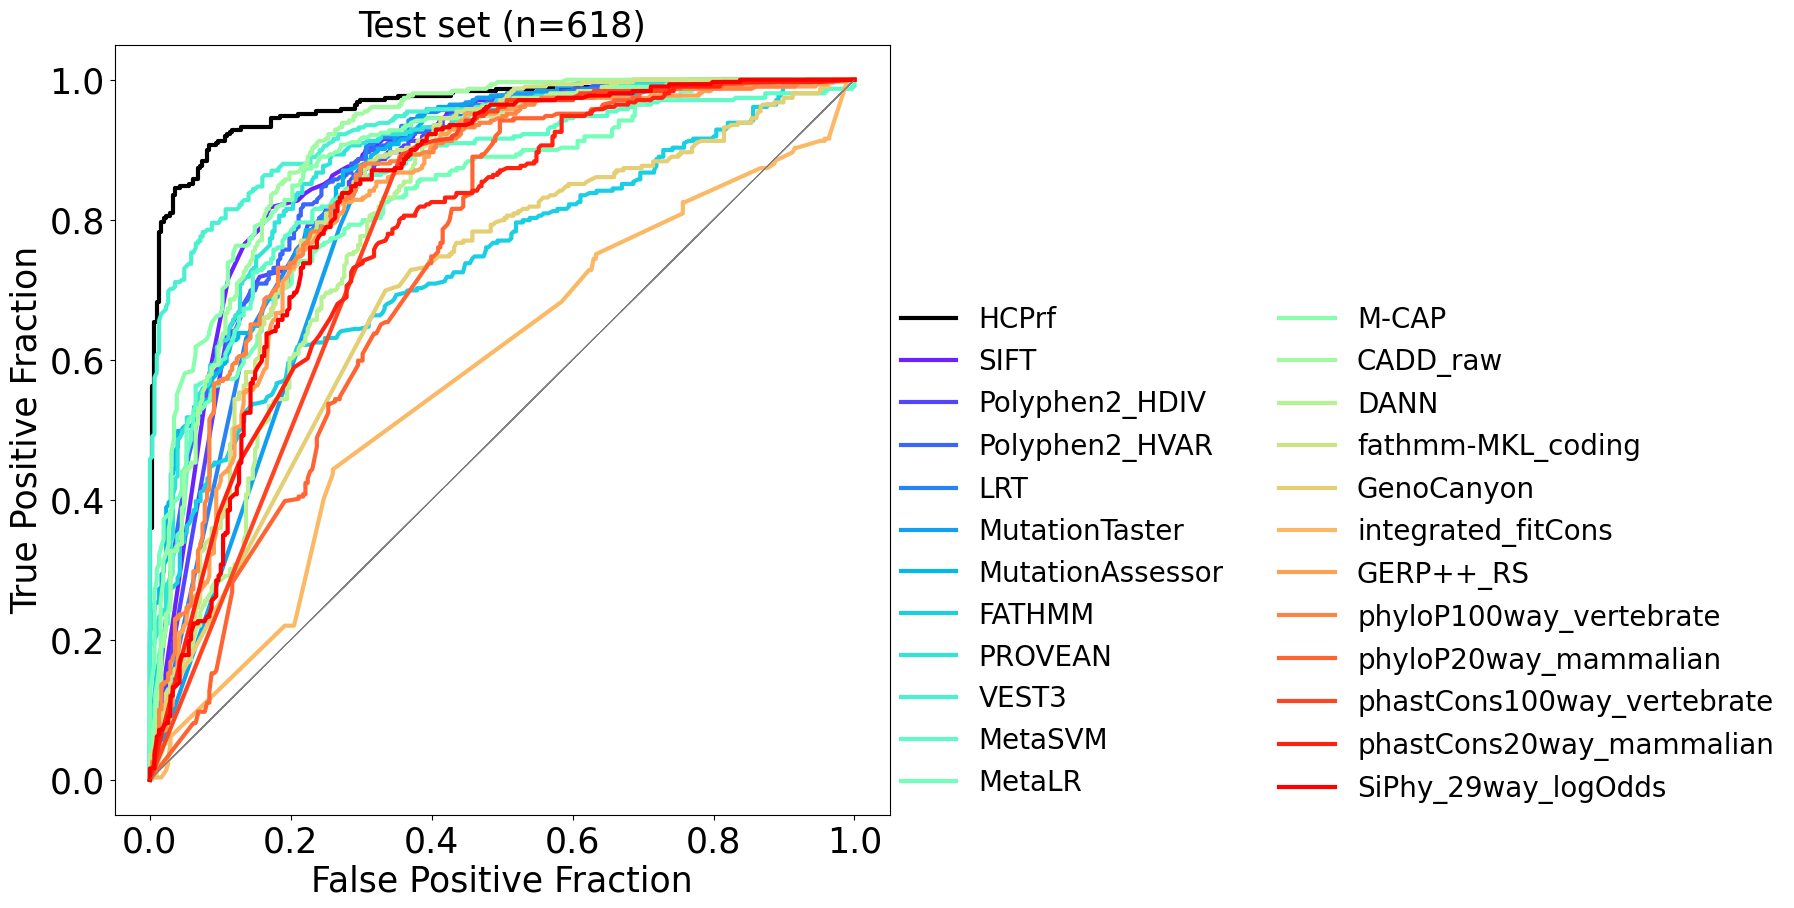

In [162]:
pred_probs = ["HCPrf_prob",
              'SIFT_converted_rankscore', 
              'Polyphen2_HDIV_rankscore',
              'Polyphen2_HVAR_rankscore',
              'LRT_converted_rankscore',
              'MutationTaster_converted_rankscore',
              'MutationAssessor_score_rankscore',
              'FATHMM_converted_rankscore',
              'PROVEAN_converted_rankscore', 
              'VEST3_rankscore',
              'MetaSVM_rankscore', 
              'MetaLR_rankscore',
              'M-CAP_rankscore', 
              'CADD_raw_rankscore',
              'DANN_rankscore',
              'fathmm-MKL_coding_rankscore', 
              'GenoCanyon_score_rankscore',
              'integrated_fitCons_score_rankscore',
              'GERP++_RS_rankscore',
              'phyloP100way_vertebrate_rankscore',
              'phyloP20way_mammalian_rankscore', 
              'phastCons100way_vertebrate_rankscore',
              'phastCons20way_mammalian_rankscore',
              'SiPhy_29way_logOdds_rankscore']

colors = []
for i in range(len(pred_probs)-1):
    color = plt.cm.seismic(np.linspace(0, 1, len(pred_probs)-1))
    colors.append(color)
    
plt.figure(figsize=(10,10))
for i, p in enumerate(pred_probs):
    color = plt.cm.rainbow(np.linspace(0, 1, len(pred_probs)))
    dx = df.loc[~df[p].isna()]
    # print(len(dx))
    # print(p)
    fpr, tpr, thres = metrics.roc_curve(dx["two_states"], dx[p])
    dr = {"name":p,"fpr":fpr,"tpr":tpr,"scores":thres}
    dr = pd.DataFrame(dr)
    if p == "HCPrf_prob":
        auc = roc_auc_score(dx["two_states"], dx[p])
        x = p.replace("_prob","")
        plt.plot(fpr,tpr,label=x,color="black",linewidth=3)
        plt.legend(loc =(1,0),ncol= 1,frameon=False,fontsize=20)
        print(x, f"{auc:.3f}")
    else:
        auc = roc_auc_score(dx["two_states"], dx[p]) 
        p = p.replace("_rankscore","")
        p = p.replace("_score","")
        p = p.replace("_converted","")
        x = p.replace("_prob","")
        plt.plot(fpr,tpr,label=x,color=color[i],linewidth=3)
        plt.plot([0,0.5,1],[0,0.5,1],color ="grey",linestyle="-",linewidth=0.5)
        plt.ylabel('True Positive Fraction',fontsize=25)
        plt.xlabel('False Positive Fraction',fontsize=25)
        plt.tick_params(axis='both', which='both', labelsize=25)
        plt.legend(loc =(1,0),ncol= 2,frameon=False,fontsize=20)
        plt.title("Test set (n="+str(len(df))+")",fontsize=25,x=0.5, y=1.0)

        # print(x, f"{auc:.3f}")

plt.savefig('RF_ROCtest.png', facecolor='w', bbox_inches='tight', pad_inches=0.01)     